In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d

import time
import matplotlib.dates as md



%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import pandas as pd

import networkx as nx

import datetime

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
test_data = np.load("../DCRNN/data/OUR/test.npz")

test_avgs = np.load("test_hist_avg.npz")['x'][:,:,13,1]


cleaner_test = [max(np.append(tx,ty)) == ty[-1] for tx,ty in zip(test_data['x'][:,:,0,1],test_data['y'][:,:,0,1])]

cats = [cat for cat in test_data]

cleaned_test_data = dict()
for cat in cats[:2]:
    cleaned_test_data[cat] = test_data[cat][cleaner_test]

In [16]:
ground_truth = cleaned_test_data['y'][:,:,13,0]

fc_pred = torch.load("./jan_fc01.pt").detach().numpy()
fc_pred_avg = torch.load("./jan_fc01_avg_1node.pt").detach().numpy()
fc_pred_avg_2nodes = torch.load("./jan_fc01_avg_2nodes.pt").detach().numpy()
fc_pred_avg_3nodes = torch.load("./jan_fc01_avg_3nodes.pt").detach().numpy()


fc_pred_avg_1node_aug = torch.load("./jan_fc01_avg_1node_dataaug.pt").detach().numpy()

dcrnn_pred = np.load("../DCRNN/data/our_dcrnn_predictions.npz")['predictions'][:,cleaner_test,13]
dcrnn_pred = np.swapaxes(dcrnn_pred, 0, 1)

In [17]:
ground_truth.shape, dcrnn_pred.shape

((4643, 12), (4643, 12))

In [18]:
start_day = datetime.datetime.strptime("2000-01-01 00:00:00",'%Y-%m-%d %H:%M:%S')

t =  cleaned_test_data['y'][:,3,0,1][0]
dates = np.array([start_day + datetime.timedelta(minutes = int(np.timedelta64(int(t*24*60), "m")/np.timedelta64(1,'m'))) for t in cleaned_test_data['y'][:,3,0,1]])

In [19]:
days_inds = [np.arange(len(dates))[i:i+180] for i in range(118,len(dates),181)]

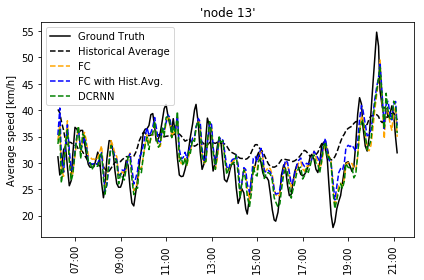

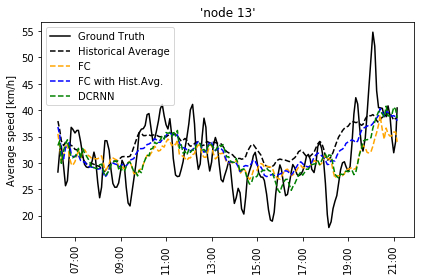

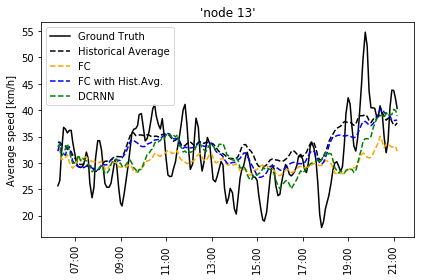

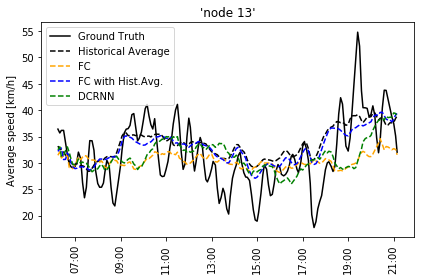

In [51]:
for i in [1,3,7,11]:
    day = 5
    slic = days_inds[day]
    pred_step = i

    datenums=md.date2num(dates)
    plt.subplots_adjust(bottom=0.1)
    plt.xticks( rotation=90 )
    ax=plt.gca()
    xfmt = md.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    
    
    plt.plot(dates[slic], ground_truth[slic,pred_step]*162, color = 'black', label = 'Ground Truth', linewidth = 1.5)
    plt.plot(dates[slic], test_avgs[slic,pred_step]*162, color = 'black', label = 'Historical Average', linewidth = 1.5, linestyle = '--')


    plt.plot(dates[slic], fc_pred[slic,pred_step]*162, color = 'orange', label = 'FC', linewidth = 1.5, linestyle = '--')
    plt.plot(dates[slic], fc_pred_avg[slic,pred_step]*162, color = 'blue', label = 'FC with Hist.Avg.', linewidth = 1.5, linestyle = '--')
    plt.plot(dates[slic], dcrnn_pred[slic,pred_step]*162, color = 'green', label = 'DCRNN', linewidth = 1.5, linestyle = '--')
    
    


    plt.ylabel("Average speed [km/h]")
    plt.legend(loc = 'upper left')
    plt.title("'node 13'")

    plt.tight_layout()
    name = "vis_pred_diff_day_" + str(day) +  "_horizon" + str(i) + ".png"
    plt.savefig(name, dpi = 400)
    plt.show()

In [25]:
differences_fc = np.array([np.sum((ground_truth[:,i] - fc_pred[:,i])**2)/len(ground_truth)*162**2 for i in range(12)])

differences_avg = np.array([np.sum((ground_truth[:,i] - test_avgs[:,i])**2)/len(ground_truth)*162**2 for i in range(12)])

differences_fc_avg = np.array([np.sum((ground_truth[:,i] - fc_pred_avg[:,i])**2)/len(ground_truth)*162**2 for i in range(12)])

differences_fc_avg_2nodes = np.array([np.sum((ground_truth[:,i] - fc_pred_avg_2nodes[:,i])**2)/len(ground_truth)*162**2 for i in range(12)])

differences_fc_avg_3nodes = np.array([np.sum((ground_truth[:,i] - fc_pred_avg_3nodes[:,i])**2)/len(ground_truth)*162**2 for i in range(12)])


differences_fc_1node_aug = np.array([np.sum((ground_truth[:,i] - fc_pred_avg_1node_aug[:,i])**2)/len(ground_truth)*162**2 for i in range(12)])

differences_dcrnn = np.array([np.sum((ground_truth[:,i] - dcrnn_pred[:,i])**2)/len(ground_truth)*162**2 for i in range(12)])

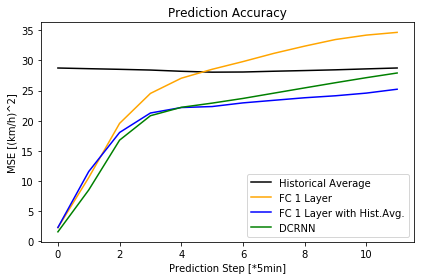

In [31]:
plt.ylabel("MSE [(km/h)^2]")
plt.xlabel("Prediction Step [*5min]")
plt.title("Prediction Accuracy")

plt.plot(differences_avg, color = 'black', label = "Historical Average")
plt.plot(differences_fc, color = 'orange', label = "FC 1 Layer")
plt.plot(differences_fc_avg, color = 'blue', label = "FC 1 Layer with Hist.Avg.")
#plt.plot(differences_fc_avg_2nodes, color = 'pink', linestyle = '--')
#plt.plot(differences_fc_avg_3nodes, color = 'pink')
plt.plot(differences_dcrnn, color = 'green', label = "DCRNN")

plt.legend(loc = 'lower right')

plt.tight_layout()

plt.savefig("accuracy.png", dpi = 400)

In [193]:
np.sum( (ground_truth - test_avgs))/(len(ground_truth) * 12)

-0.02917881396568058

In [194]:
fc_pred_avg_2nodes

array([[0.14130257, 0.1625288 , 0.19770768, ..., 0.18529025, 0.18643786,
        0.18557106],
       [0.20058785, 0.21280704, 0.21855006, ..., 0.18571904, 0.1866015 ,
        0.18580256],
       [0.26160225, 0.24903272, 0.23368959, ..., 0.19022998, 0.1905302 ,
        0.18922691],
       ...,
       [0.26612392, 0.24392554, 0.24635111, ..., 0.2181072 , 0.21865371,
        0.21903588],
       [0.24056605, 0.22944275, 0.2376523 , ..., 0.21912143, 0.2208946 ,
        0.22158843],
       [0.24305683, 0.23863281, 0.24451913, ..., 0.2197161 , 0.22430657,
        0.22355644]], dtype=float32)